In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/train',
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/val',
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('food_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 20057 files belonging to 55 classes.
Found 5186 files belonging to 55 classes.
['Alpukat', 'Anggur', 'Apel', 'Asparagus', 'Brokoli', 'Buah naga', 'Ceker ayam', 'Dada ayam', 'Durian', 'Jagung', 'Jambu Air', 'Jeruk', 'Kacang Mete', 'Kacang polong', 'Kacang tanah', 'Kangkung', 'Kelapa', 'Kembang Kol', 'Kentang', 'Klengkeng', 'Kulit ayam', 'Labu', 'Labu Siam', 'Leci', 'Lemon', 'Lobak Merah', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Nangka', 'Nasi merah', 'Nasi putih', 'Paha bawah ayam', 'Paprika', 'Pare', 'Pepaya', 'Pir', 'Pisang', 'Pokcoy', 'Pork belly', 'Rambutan', 'Salmon', 'Sayap Ayam', 'Semangka', 'Singkong', 'Stroberi', 'Tahu', 'Tauge', 'Telur', 'Tempe', 'Terong', 'Tomat', 'Ubi', 'Wortel']


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

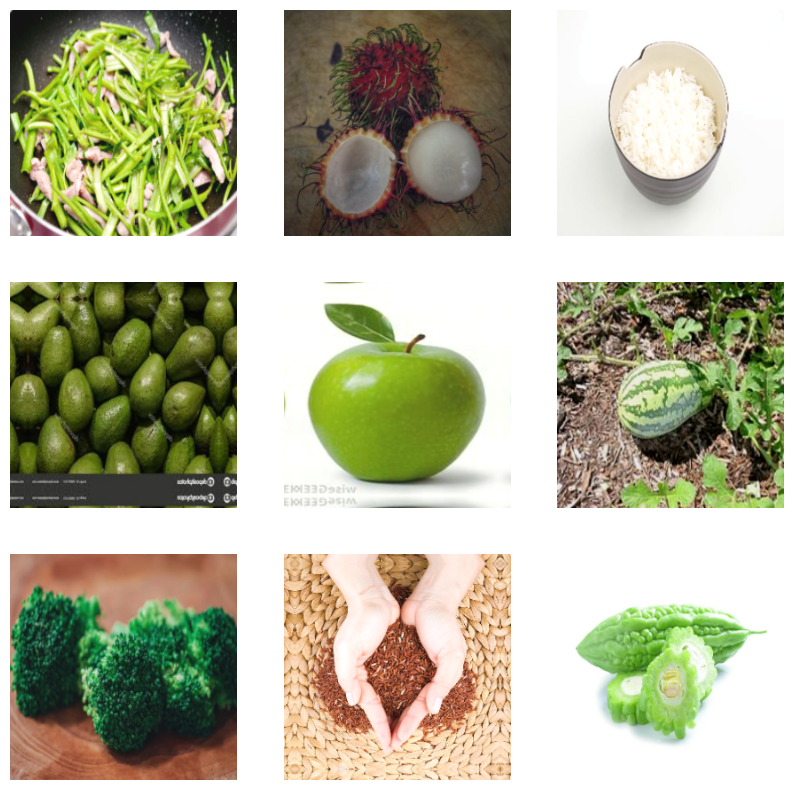

In [5]:
#Define a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [6]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
x = pre_trained.output
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = tf.keras.layers.Dense(2048, activation='relu')(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

food_model = tf.keras.models.Model(inputs = pre_trained.input,
                                   outputs = predictions
                                  )

food_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                  )

food_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 10, 
                                        mode = 'min', 
                                        restore_best_weights = True)

history = food_model.fit(train_ds,
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = [early_stopping_callback]
                        )

Epoch 1/100
157/157 [==============================] - 311s 2s/step - loss: 14.5469 - accuracy: 0.0774 - val_loss: 10.9912 - val_accuracy: 0.0727
Epoch 2/100
157/157 [==============================] - 247s 2s/step - loss: 9.1864 - accuracy: 0.1126 - val_loss: 9.2052 - val_accuracy: 0.1007
Epoch 3/100
157/157 [==============================] - 245s 2s/step - loss: 8.3867 - accuracy: 0.1314 - val_loss: 9.5776 - val_accuracy: 0.1128
Epoch 4/100
157/157 [==============================] - 246s 2s/step - loss: 7.8476 - accuracy: 0.1459 - val_loss: 8.5422 - val_accuracy: 0.1338
Epoch 5/100
157/157 [==============================] - 246s 2s/step - loss: 7.3109 - accuracy: 0.1609 - val_loss: 8.4598 - val_accuracy: 0.1267
Epoch 6/100
157/157 [==============================] - 246s 2s/step - loss: 7.0547 - accuracy: 0.1704 - val_loss: 7.5988 - val_accuracy: 0.1365
Epoch 7/100
157/157 [==============================] - 246s 2s/step - loss: 6.9094 - accuracy: 0.1775 - val_loss: 8.1448 - val_accurac

41/41 [==============================] - 18s 364ms/step - loss: 6.5720 - accuracy: 0.1664


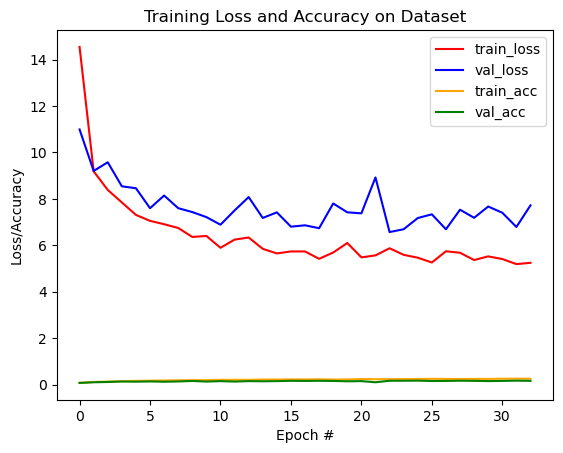

In [9]:
model_evaluation = food_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [10]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [11]:
current_datetime = datetime.now()

# Save Model
food_model.save(f'food_model_{current_datetime}')

# Save .h5 model
food_model.save(f'food_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./food_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'food_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

In [12]:
count = 0

for root_dir, cur_dir, files in os.walk('/kaggle/input/food-ingredients/Food Dataset/test'):
    count += len(files)

val_split = 0.25
batch = int(val_split*count)
    
ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/test',
                                                 labels='inferred',
                                                 label_mode='categorical',
                                                 image_size=img_size,
                                                 shuffle=True,
                                                 subset='validation',
                                                 validation_split=val_split,
                                                 batch_size=batch,
                                                 seed=127
                                                )

#define labels for testing
for images, test_labels in ds.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
    y_labels = test_labels.numpy()

y_labels = np.argmax(y_labels, axis=1)

#make prediction
y_preds = np.argmax(food_model.predict(ds), axis=1)

#get classification report
print(classification_report(y_labels, y_preds, target_names=labels))

Found 2576 files belonging to 55 classes.
Using 644 files for validation.
1/1 [==============================] - 8s 8s/step
                 precision    recall  f1-score   support

        Alpukat       0.00      0.00      0.00        14
         Anggur       0.10      0.06      0.08        16
           Apel       0.00      0.00      0.00        15
      Asparagus       0.00      0.00      0.00        17
        Brokoli       0.00      0.00      0.00        16
      Buah naga       0.00      0.00      0.00        12
     Ceker ayam       0.00      0.00      0.00        12
      Dada ayam       0.00      0.00      0.00        19
         Durian       0.02      0.20      0.04        10
         Jagung       0.00      0.00      0.00        18
      Jambu Air       0.00      0.00      0.00        13
          Jeruk       0.00      0.00      0.00        11
    Kacang Mete       0.00      0.00      0.00        11
  Kacang polong       0.00      0.00      0.00        10
   Kacang tanah     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,12))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

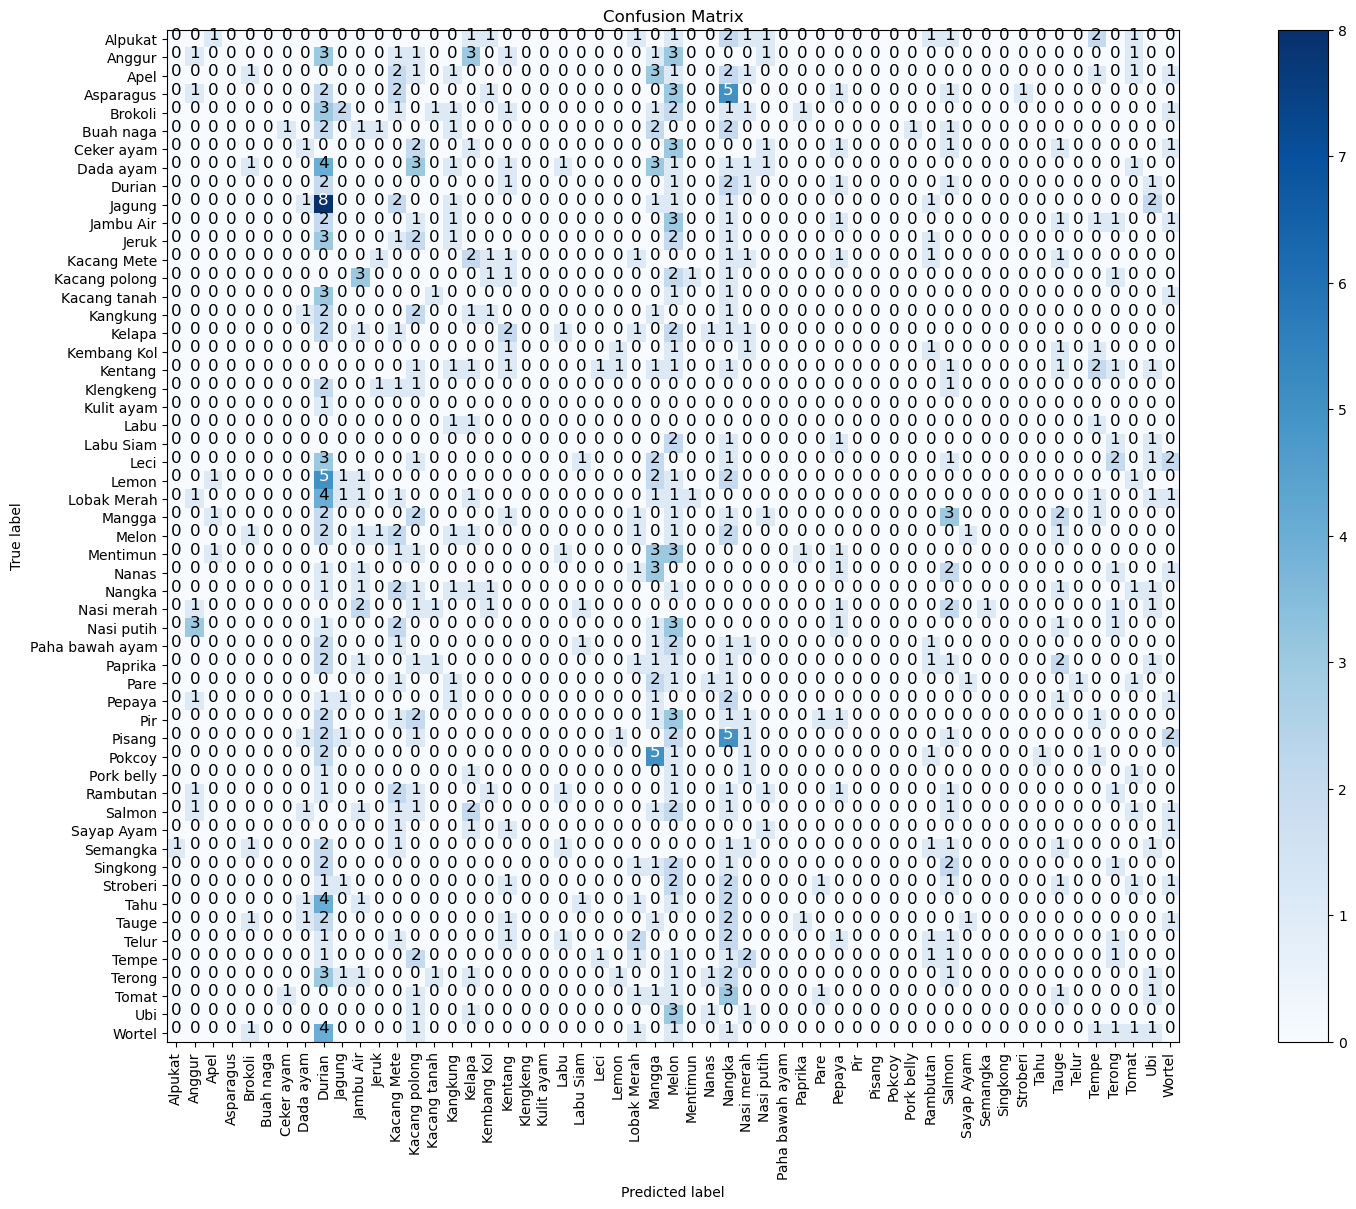

In [14]:
#get confusion matrix
cm = confusion_matrix(y_labels, y_preds)
# print(cm)

#plot
plot_confusion_matrix(cm, labels, normalize=False)

Nasi merah/istockphoto-518226537-612x612.jpg
1/1 [==============================] - 1s 1s/step
[1.34428831e-07 9.35916905e-05 1.58520308e-08 4.96688062e-06
 5.09688910e-03 9.00239172e-09 3.25412002e-05 6.29300985e-08
 3.02090328e-02 1.18158414e-06 1.74028298e-06 3.49106966e-04
 7.50052720e-07 1.10144254e-04 5.04028357e-08 5.31759083e-01
 1.79514376e-04 7.24846174e-08 1.72897149e-02 6.12217207e-07
 3.96847418e-27 6.05598558e-03 1.17579282e-06 3.44586546e-08
 8.68477969e-07 9.27338842e-03 4.77336016e-06 6.78867549e-02
 2.77327800e-10 5.15308933e-13 1.23107638e-02 2.91991919e-01
 5.16733962e-06 2.62634936e-09 1.75783936e-11 3.17391568e-05
 1.66648588e-05 1.83609816e-09 2.40275853e-08 6.51096677e-11
 6.47345288e-09 2.67847590e-02 8.58983185e-05 1.17505170e-08
 7.85455029e-07 2.23019782e-07 2.85461238e-06 2.08206970e-04
 8.96534491e-09 2.98144265e-08 1.00129233e-04 9.88253742e-05
 7.82363031e-07 8.99859424e-06 1.26505446e-08]
predicted food: Kangkung 
confidence: 0.5317590832710266 


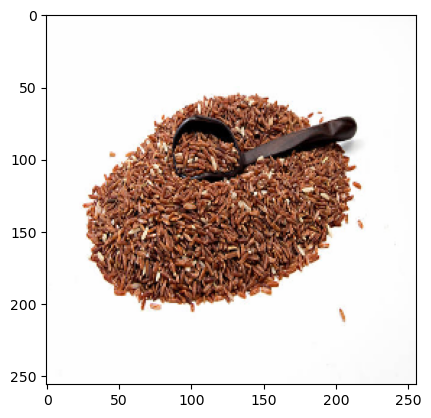

In [15]:
random_classes_names = random.choice(os.listdir('/kaggle/input/food-ingredients/Food Dataset/test'))
random_file = random.choice(os.listdir(f'/kaggle/input/food-ingredients/Food Dataset/test/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

img_test = cv2.imread(f'/kaggle/input/food-ingredients/Food Dataset/test/{random_classes_names}/{random_file}')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size))
plt.imshow(img_test)

prediction = food_model.predict(np.expand_dims(img_test, axis=0))[0]
predicted_label = np.argmax(prediction)

print(prediction)
print(f'predicted food: {labels[predicted_label]} \nconfidence: {prediction[predicted_label]} ')